# 예약 매출 예측 모델 v2

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils import data

random_seed = 20181401
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
class MyDataset(data.Dataset):
  def __init__(self):
    super().__init__()
    self.x_trains = [
      [395, 517, 40, 40,],
      [425, 589, 45, 50,],
      [441, 613, 34, 57,],
      [407, 580, 39, 50,],
      [333, 539, 40, 31,],
      [334, 450, 26, 28,],
      [409, 521, 28, 52,],
      [372, 529, 29, 44,],
      [382, 571, 33, 50,],
      [413, 606, 42, 51,],
    ]
    self.y_trains = [
      [23685.2654,],
      [26223.6202,],
      [26596.5754,],
      [26549.5062,],
      [23935.5809,],
      [19377.2396,],
      [24493.6178,],
      [21757.2808,],
      [24278.4222,],
      [26529.5144,],
    ]
  
  def __len__(self):
    return len(self.x_trains)
  
  def __getitem__(self, index):
    return (
      torch.FloatTensor(self.x_trains[index]).to(device),
      torch.FloatTensor(self.y_trains[index]).to(device),
    )

In [3]:
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(4, 1)
  
  def forward(self, x):
    return self.linear(x)

In [4]:
dataset = MyDataset()
dataloader = data.DataLoader(dataset, batch_size=4, shuffle=True, drop_last=True)
model = MyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print([*dataset], [*model.named_parameters()], optimizer)

[(tensor([395., 517.,  40.,  40.], device='cuda:0'), tensor([23685.2656], device='cuda:0')), (tensor([425., 589.,  45.,  50.], device='cuda:0'), tensor([26223.6211], device='cuda:0')), (tensor([441., 613.,  34.,  57.], device='cuda:0'), tensor([26596.5762], device='cuda:0')), (tensor([407., 580.,  39.,  50.], device='cuda:0'), tensor([26549.5059], device='cuda:0')), (tensor([333., 539.,  40.,  31.], device='cuda:0'), tensor([23935.5801], device='cuda:0')), (tensor([334., 450.,  26.,  28.], device='cuda:0'), tensor([19377.2402], device='cuda:0')), (tensor([409., 521.,  28.,  52.], device='cuda:0'), tensor([24493.6172], device='cuda:0')), (tensor([372., 529.,  29.,  44.], device='cuda:0'), tensor([21757.2812], device='cuda:0')), (tensor([382., 571.,  33.,  50.], device='cuda:0'), tensor([24278.4219], device='cuda:0')), (tensor([413., 606.,  42.,  51.], device='cuda:0'), tensor([26529.5137], device='cuda:0'))] [('linear.weight', Parameter containing:
tensor([[ 0.4385,  0.1300,  0.2423, -0

In [5]:
epoch = 1
mean_costs = []

while epoch <= 120000:
  costs = []

  for iteration, batch in enumerate(dataloader):
    H = model(batch[0])
    cost = nn.functional.mse_loss(H, batch[1])
    # abs_cost = nn.functional.l1_loss(H, batch[1])
    costs.append(cost.item())
  
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
  
  if epoch == 1 or epoch % 2000 == 0:
    mean_costs.append([epoch, np.mean(costs)])

    if epoch == 1 or epoch % 10000 == 0:
      print(mean_costs[-1])
  
  epoch += 1

[1, 579847136.0]
[10000, 516533536.0]
[20000, 395660672.0]
[30000, 312164256.0]
[40000, 267208480.0]
[50000, 194685800.0]
[60000, 140862352.0]
[70000, 102339324.0]
[80000, 67031782.0]
[90000, 38026642.0]
[100000, 15732072.5]
[110000, 4306025.75]
[120000, 467125.296875]


[('linear.weight', Parameter containing:
tensor([[23.7799, 23.4666, 23.5423, 22.7986]], device='cuda:0',
       requires_grad=True)), ('linear.bias', Parameter containing:
tensor([23.2396], device='cuda:0', requires_grad=True))]


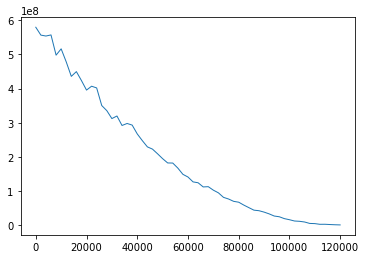

In [6]:
print([*model.named_parameters()])
plt.plot(*zip(*mean_costs), linewidth=1)
plt.show()